In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

DATA_PATH = 'data/'


In [2]:
df1 = pd.read_csv(os.path.join(DATA_PATH, 'season1819.csv'))
df2 = pd.read_csv(os.path.join(DATA_PATH, 'season1718.csv'))
df3 = pd.read_csv(os.path.join(DATA_PATH, 'season1617.csv'))
df4 = pd.read_csv(os.path.join(DATA_PATH, 'season1516.csv'))
df5 = pd.read_csv(os.path.join(DATA_PATH, 'season1415.csv'))
df6 = pd.read_csv(os.path.join(DATA_PATH, 'season1314.csv'))
df7 = pd.read_csv(os.path.join(DATA_PATH, 'season1213.csv'))
df8 = pd.read_csv(os.path.join(DATA_PATH, 'season1112.csv'))
df9 = pd.read_csv(os.path.join(DATA_PATH, 'season1011.csv'))
df10 = pd.read_csv(os.path.join(DATA_PATH, 'season0910.csv'))
df11 = pd.read_csv(os.path.join(DATA_PATH, 'season0809.csv'))
df12 = pd.read_csv(os.path.join(DATA_PATH, 'season0708.csv'))

all_seasons = [df1, df2, df3, df4, df5, df6,
               df7, df8, df9, df10,df11,df12]

H    0.462061
A    0.288596
D    0.249342
Name: FTR, dtype: float64


/home/stephen/Projects/betting_model/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


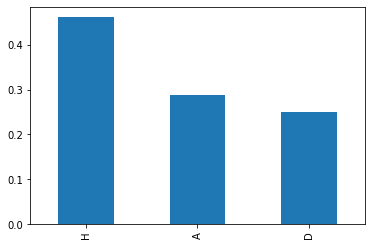

In [3]:
df = pd.concat([df1, df2, df3, df4, df5, df6,
               df7, df8, df9, df10,df11,df12], ignore_index=True)
results = df['FTR'].value_counts(normalize=True)
print(results)
results.plot(kind='bar')
plt.show()

In [108]:
for season in all_seasons:
    results = season['FTR'].value_counts(normalize=True)
    print(results)


H    0.476316
A    0.336842
D    0.186842
Name: FTR, dtype: float64
H    0.455263
A    0.284211
D    0.260526
Name: FTR, dtype: float64
H    0.492105
A    0.286842
D    0.221053
Name: FTR, dtype: float64
H    0.413158
A    0.305263
D    0.281579
Name: FTR, dtype: float64
H    0.452632
A    0.302632
D    0.244737
Name: FTR, dtype: float64
H    0.471053
A    0.323684
D    0.205263
Name: FTR, dtype: float64
H    0.436842
D    0.284211
A    0.278947
Name: FTR, dtype: float64
H    0.450000
A    0.305263
D    0.244737
Name: FTR, dtype: float64
H    0.471053
D    0.292105
A    0.236842
Name: FTR, dtype: float64
H    0.507895
D    0.252632
A    0.239474
Name: FTR, dtype: float64
H    0.455263
A    0.289474
D    0.255263
Name: FTR, dtype: float64
H    0.463158
A    0.273684
D    0.263158
Name: FTR, dtype: float64


We can see that home advantage has a big effect on outcome. If our classifier was to predict only home wins it would get around 46% correct. We can use this as a benchmark. Let's see how accurate the bookies are now.

In [109]:
correct = 0
home = 0
for i in range(len(df)):
    favourite = np.argmin([df['B365H'][i], df['B365D'][i], df['B365A'][i]])
    if favourite == 0:
        home +=1
    if df['FTR'][i] == 'H' and favourite == 0:
        correct +=1
    elif df['FTR'][i] == 'D' and favourite == 1:
        correct +=1
    elif df['FTR'][i] == 'A' and favourite == 2:
        correct +=1

In [110]:
correct

2506

In [111]:
correct / len(df)

0.549440912080684

In [112]:
home

3211

We can see that the bookies have pretty good accuracy, around 55%. They seem to rely on home advantage to make their prediction. Also the bookies never predicted any draws in this dataset. 

Let's split the data to X and y and have a look at the confusion matrix. 

In [2]:
df = pd.read_csv('data/training_data.csv')
df.shape

(4560, 40)

In [22]:
X_all = df.drop(['FTR', 'Unnamed: 0', 'Date', 'HomeTeam', 'AwayTeam', 
                 'HTGS', 'ATGS', 'HTGC', 'ATGC', 'HM4', 'HM5', 'AM4', 
                 'AM5', 'HTSF', 'HTSA', 'ATSF', 'ATSA', 'MW', 'HTFormPts', 'ATFormPts',
                        'HTFormPtsStr', 'ATFormPtsStr', 'HTSD', 'ATSD'], 1)
Y_all = df['FTR']

print('Number of matches:', X_all.shape[0])
print('Number of features:', X_all.shape[1])

Number of matches: 4560
Number of features: 16


# Prepare the data

We will now split the data into training and testing and scale our data.

We can come back and try feature engineering later.

In [23]:
def transform_results(results):
    transformed = []
    for i in range(len(results)):
        if results[i] == 'H':
            transformed.append(0)
        elif results[i] == 'A':
            transformed.append(2)
        else:
            transformed.append(1)
    return np.array(transformed)
            
Y_all = transform_results(Y_all)

In [24]:
#we want continous vars that are integers for our input data, so lets remove any categorical vars
def preprocess_features(X):
    ''' Preprocesses the football data and converts catagorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
                    
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)

In [25]:
# Sca;e our numeric columns
scaler = StandardScaler()
cols = [['HTP', 'ATP', 'HTGD', 'ATGD', 'DiffFormPts',
        'B365H', 'B365D', 'B365A', 'DiffLP', 'DiffPts']]
for col in cols:
        X_all[col] = scaler.fit_transform(X_all[col])

In [26]:
X_all.columns

Index(['HTP', 'ATP', 'B365H', 'B365D', 'B365A', 'HM1_D', 'HM1_L', 'HM1_M',
       'HM1_W', 'HM2_D', 'HM2_L', 'HM2_M', 'HM2_W', 'HM3_D', 'HM3_L', 'HM3_M',
       'HM3_W', 'AM1_D', 'AM1_L', 'AM1_M', 'AM1_W', 'AM2_D', 'AM2_L', 'AM2_M',
       'AM2_W', 'AM3_D', 'AM3_L', 'AM3_M', 'AM3_W', 'HTGD', 'ATGD', 'DiffPts',
       'DiffFormPts', 'DiffLP'],
      dtype='object')

for now we will use the last season for testing

In [89]:
X = X_all[380:]
Y = Y_all[380:]
X_test = X_all[:380]
y_test = Y_all[:380]

In [11]:
model = RandomForestClassifier(n_estimators=1500, max_depth=8,
                               min_samples_leaf=3, n_jobs=-1,
                               random_state=42, verbose=1)


In [18]:
season_len = 380
results = []
for i in range(12):
    idx = i * season_len
    X = np.concatenate((X_all[:idx], X_all[idx+380:]))
    Y = np.concatenate((Y_all[:idx], Y_all[idx+380:]))
    X_test = X_all[idx:idx+380]
    y_test = Y_all[idx:idx+380]
    
    model.fit(X, Y)
    y_preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_preds)
    print(accuracy)
    results.append(accuracy)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    2.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 1500 out of 1500 | elapsed:    0.5s finished


0.5947368421052631


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    2.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 1500 out of 1500 | elapsed:    0.5s finished


0.5447368421052632


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    2.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 1500 out of 1500 | elapsed:    0.5s finished


0.6105263157894737


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    2.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 1500 out of 1500 | elapsed:    0.5s finished


0.4789473684210526


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    2.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 1500 out of 1500 | elapsed:    0.4s finished


0.5289473684210526


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    2.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 1500 out of 1500 | elapsed:    0.5s finished


0.6052631578947368


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    2.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 1500 out of 1500 | elapsed:    0.5s finished


0.5342105263157895


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    2.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 1500 out of 1500 | elapsed:    0.5s finished


0.5394736842105263


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    2.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 1500 out of 1500 | elapsed:    0.5s finished


0.5078947368421053


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    2.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 1500 out of 1500 | elapsed:    0.5s finished


0.5710526315789474


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    2.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 1500 out of 1500 | elapsed:    0.5s finished


0.531578947368421


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    2.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.4s


0.5736842105263158


[Parallel(n_jobs=12)]: Done 1500 out of 1500 | elapsed:    0.5s finished


In [19]:
print(f'Average accuracy :{sum(results)/len(results)}')
print(f'Min accuracy :{min(results)}')
print(f'Max accuracy :{max(results)}')
print(f'Standard Deviation :{np.std(results)}')

Average accuracy :0.5517543859649122
Min accuracy :0.4789473684210526
Max accuracy :0.6105263157894737
Standard Deviation :0.03838157869677049


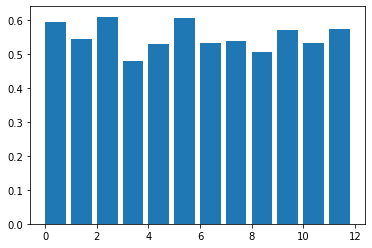

In [14]:
bins = [i for i in range(len(results))]
plt.bar(bins, results, align='edge')
plt.show()

In [104]:
results

[0.6052631578947368,
 0.5473684210526316,
 0.6026315789473684,
 0.48157894736842105,
 0.5289473684210526,
 0.6026315789473684,
 0.531578947368421,
 0.5394736842105263,
 0.5131578947368421,
 0.5736842105263158,
 0.5263157894736842,
 0.5894736842105263]

In [140]:
for col, importance in zip(X_all.columns, model.feature_importances_):
    print(col, importance)

HTP 0.034115580365994366
ATP 0.030986248460692277
B365H 0.5204356779119939
B365D 0.07280107880872572
B365A 0.1425309670557084
HM1_D 0.008406150418563282
HM1_L 0.002973901575991384
HM1_M 0.0
HM1_W 0.009922785805635173
HM2_D 0.0
HM2_L 0.0007398032353477757
HM2_M 0.0
HM2_W 0.0
HM3_D 0.0010000226973583227
HM3_L 0.001277884712172643
HM3_M 0.0
HM3_W 0.0
AM1_D 0.006225240354927263
AM1_L 0.027269319685627576
AM1_M 0.0
AM1_W 0.011333630059719945
AM2_D 0.0
AM2_L 0.0
AM2_M 0.0
AM2_W 0.0017416292807036597
AM3_D 0.0005170789866313664
AM3_L 0.0024388306914882455
AM3_M 0.0
AM3_W 0.00043137567442527665
HTGD 0.026272414907787967
ATGD 0.033394894924648116
DiffPts 0.021460292573301877
DiffFormPts 0.0199669624497407
DiffLP 0.02375822936281478


In [137]:
gb_model = GradientBoostingClassifier(n_estimators=75, max_depth=2,
                                      verbose=1, random_state=42)

52.6% is a decent benchmark, this is significantly higher than if the model just predicted home wins but it is still some way off the bookies model. We can now try some other models and look at tuning hyperparameters, we may also want to try some more feature engineering. 

In [138]:
season_len = 380
results = []
for i in range(12):
    idx = i * season_len
    X = np.concatenate((X_all[:idx], X_all[idx+380:]))
    Y = np.concatenate((Y_all[:idx], Y_all[idx+380:]))
    X_test = X_all[idx:idx+380]
    y_test = Y_all[idx:idx+380]
    
    model = gb_model
    model.fit(X, Y)
    y_preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_preds)
    print(accuracy)
    results.append(accuracy)


      Iter       Train Loss   Remaining Time 
         1        4360.0427            0.82s
         2        4292.1078            0.79s
         3        4237.4933            0.77s
         4        4191.8445            0.75s
         5        4155.0363            0.74s
         6        4124.0779            0.72s
         7        4098.0524            0.71s
         8        4076.3416            0.69s
         9        4056.9230            0.67s
        10        4040.6987            0.66s
        20        3951.8395            0.54s
        30        3910.3908            0.44s
        40        3877.5601            0.33s
        50        3854.5687            0.23s
        60        3834.3716            0.14s
        70        3813.4893            0.05s
0.5868421052631579
      Iter       Train Loss   Remaining Time 
         1        4349.9607            0.73s
         2        4281.1023            0.71s
         3        4224.9148            0.71s
         4        4178.7671       

        20        3923.6665            0.57s
        30        3878.1876            0.44s
        40        3847.3428            0.34s
        50        3821.1480            0.24s
        60        3800.3173            0.14s
        70        3779.5801            0.05s
0.5210526315789473
      Iter       Train Loss   Remaining Time 
         1        4352.4687            0.74s
         2        4284.1838            0.73s
         3        4229.1495            0.72s
         4        4183.4466            0.72s
         5        4146.6318            0.71s
         6        4115.7122            0.70s
         7        4090.2840            0.69s
         8        4069.1244            0.67s
         9        4050.6658            0.66s
        10        4034.4089            0.64s
        20        3950.2475            0.53s
        30        3907.7847            0.42s
        40        3879.4658            0.32s
        50        3853.6639            0.23s
        60        3832.2739        

In [139]:
print(f'Average accuracy :{sum(results)/len(results)}')
print(f'Min accuracy :{min(results)}')
print(f'Max accuracy :{max(results)}')
print(f'Standard Deviation :{np.std(results)}')

Average accuracy :0.5530701754385966
Min accuracy :0.4868421052631579
Max accuracy :0.6078947368421053
Standard Deviation :0.039207190093164535
